In [1]:
using Plots
using Combinatorics: multiset_combinations
using DataStructures
import Base.isless

In [2]:
"""
    College(f, t, ft)

Contains a college's admissions probability `f`, utility value `t`, and their product `ft`.
"""
struct College
    f::Float64
    t::Float64
    ft::Float64
    
    College(f::Float64, t::Float64) = new(f, t, f*t)
end

isless(c1::College, c2::College) = isless(c1.ft, c2.ft)

isless (generic function with 54 methods)

In [3]:
"""
    applicationorder(f, t)

Produce the optimal order of application for the market defined by admissions probabilities `f`
and utility values `t`. 
"""
function applicationorder(f::Vector{Float64}, t::Vector{Float64})
    m = length(f)
    @assert m == length(t)
    @assert issorted(t)

    mkt = MutableBinaryMaxHeap{College}()
    for j in 1:m
        push!(mkt, College(f[j], t[j]))
    end

    onheap = trues(m)
    apporder = zeros(Int, m)
    for j in 1:m
        c_k, k = top_with_handle(mkt)
        pop!(mkt)
        
        apporder[j] = k
        onheap[k] = false
        for i in 1:k-1
            onheap[i] && update!(mkt, i, College(mkt[i].f, mkt[i].t * (1 - c_k.f)))
        end
        for i in k+1:m
            onheap[i] && update!(mkt, i, College(mkt[i].f, mkt[i].t - c_k.ft))
        end
    end
    
    return apporder
end


"""
    valuation(X, f, t)

Returns the expected value of the portfolio `X`, a vector of school indices, on the
the market defined by admissions probabilities `f` and utility values `t`. 
"""
function valuation(X::Vector{Int64}, f, t)
    @assert issorted(t)
    sort!(X)
    h = length(X)
    
    if h > 1    
        res = 0.0
        cp = reverse(cumprod(1 .- reverse(f[X[2:end]])))
    
        for j in 1:h-1
            res += t[X[j]] * f[X[j]] * cp[j]
        end
        
        res += t[X[end]] * f[X[end]]
        
        return res
    else
        return f[X[1]] * t[X[1]]
    end
end


"""
    optimalportfolio_enumerate(h, f, t)

Produce the optimal portfolio of size `h` on the market defined by admissions probabilities `f`
and utility values `t`. Solves by enumeration. 
"""
function optimalportfolio_enumerate(h, f::Vector{Float64}, t::Vector{Float64})
    m = length(t)
    X = zeros(Int, h)
    v = 0.0
    
    for Y in multiset_combinations(1:m, h)
        if (w = valuation(Y, f, t)) > v
            v = w
            X[:] = Y
        end
    end
    
    return X
end

optimalportfolio_enumerate

In [4]:
function plotsmaker()
    m = length(t)
    
    pl = [plot(
            xlabel="f",
            ylabel="t",
            size=(700, 700)
            ) for i in 1:m+2]
    
    x = zeros(Bool, m, m)
    
    scatter!(pl[1], f, t, c=:darkslategray, ms=11, msw=0, msa=0, legend=nothing)
    
    for i in 1:m
        x[optimalportfolio_enumerate(i, f, t), i] .= true
        
        scatter!(pl[i+1], f[.!x[:, i]], t[.!x[:, i]], c=:darkslategray, ms=11, msw=0, msa=0, label=nothing)
        scatter!(pl[i+1], f[x[:, i]], t[x[:, i]], c=:orangered, ms=11, msw=0, msa=0, label="apply when h = $i")
    end
    
    apporder = sortperm(reshape(sum(x, dims=2), :), rev=true)
    
    scatter!(pl[end], f, t, c=:forestgreen, ms=13, msw=0, msa=0, legend=nothing)
    annotate!(pl[end], [(f[i], t[i], text("$(apporder[i])", 9, :white)) for i in 1:m])
    
    return pl, x, apporder
end

plotsmaker (generic function with 1 method)

Solve an instance by enumeration, check that the results agree with the fast algorithm, produce a series of plots showing the nestedness property.

In [7]:
m = 20

φ = 0.7
t = rand(m) |> sort
f = 1 .- (φ*t + (1-φ)*rand(m))

@time pl, x, apporder = plotsmaker()

for c in eachcol(x)
    println(c)
end

# for p in pl
#     display(p)
# end

[apporder applicationorder(f, t)]

  6.925471 seconds (20.07 M allocations: 1.646 GiB, 5.07% gc time, 64.24% compilation time)
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Bool[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Bool[0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

20×2 Matrix{Int64}:
 19  19
 20  20
 11  11
 15  15
 13  13
 16  16
 17  17
 18  18
 14  14
 12  12
 10  10
  8   8
  6   6
  9   9
  7   7
  4   4
  5   5
  3   3
  2   2
  1   1

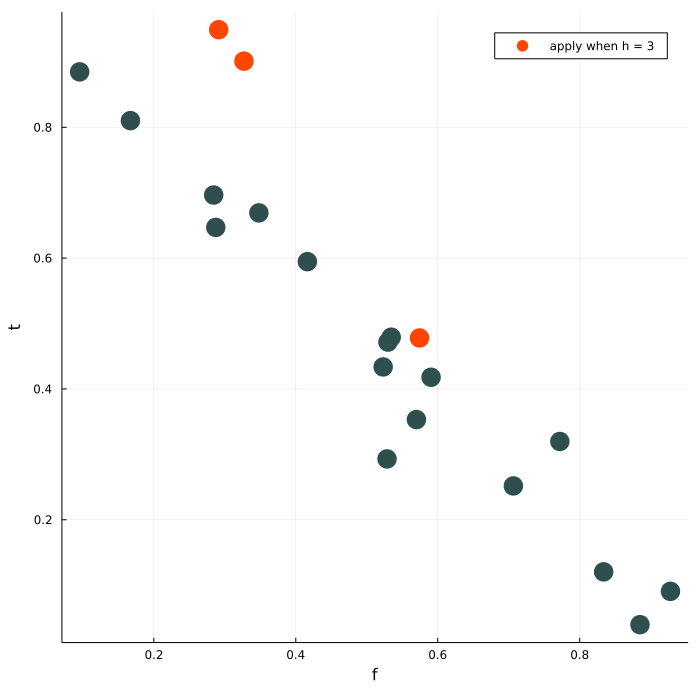

In [8]:
# for (n, i) in enumerate(pl)
#       display(i)
# end
display(pl[4])

In [47]:
for (n, i) in enumerate(pl)
    savefig(i, "optportfolio-$(n-1).png")
    savefig(i, "optportfolio-$(n-1).pdf")
end

In [33]:
for i in 0:length(pl)-1
    print("\\begin{frame}\\begin{center}\\includegraphics[height=\\textheight]{./plots/optportfolio-$i.pdf}\\end{center}\\end{frame}\n")
end

\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-0.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-1.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-2.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-3.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-4.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-5.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-6.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-7.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportf

## Example for which greedy algorithm is inoptimal

In [3]:
f = [0.4, 0.4, 0.3]
t = [0.7, 0.8, 0.9]

pl, x, apporder = plotsmaker()

so = sortperm(t .* f, rev=true)
for c in eachcol(x)
    println(c[so])
end

Bool[1, 0, 0]
Bool[1, 0, 1]
Bool[1, 1, 1]


In [311]:
[f t f .* t]

3×3 Matrix{Float64}:
 0.4  0.7  0.28
 0.4  0.8  0.32
 0.3  0.9  0.27

## Comparative statics example

In [9]:
t = Float64.(collect(range(start=200, step=50, length=8)))
f = [0.39, 0.33, 0.24, 0.24, 0.05, 0.03, 0.1, 0.12]

8-element Vector{Float64}:
 0.39
 0.33
 0.24
 0.24
 0.05
 0.03
 0.1
 0.12

In [11]:
apporder = applicationorder(f, t)
v = [valuation(apporder[1:i], f, t) for i in 1:8]

[t f apporder round.(v)[apporder]]

8×4 Matrix{Float64}:
 200.0  0.39  4.0  230.0
 250.0  0.33  2.0  147.0
 300.0  0.24  8.0  294.0
 350.0  0.24  1.0   84.0
 400.0  0.05  7.0  289.0
 450.0  0.03  3.0  195.0
 500.0  0.1   5.0  258.0
 550.0  0.12  6.0  282.0

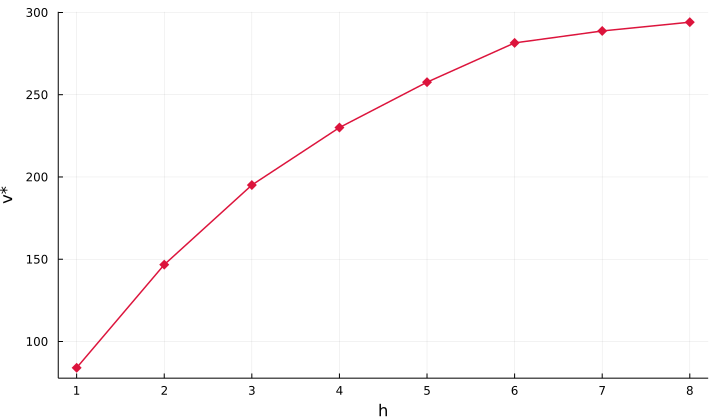

In [12]:
pl = plot(v, legend=false, size=(720, 420), xlabel="h", ylabel="v*", lw=1.5, color=:crimson, xticks=1:8, marker=:diamond, msw=0, msa=0, ms=5)

In [41]:
savefig(pl, "h-utility.png")
savefig(pl, "h-utility.pdf")